<a href="https://colab.research.google.com/github/aCStandke/GAN_Models/blob/main/NeuralTransferModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Neural Style Transfer

This is an implementation of the Neural Style Transfer tutorial as detailed at [Neural style transfer](https://www.tensorflow.org/tutorials/generative/style_transfer)

> This tutorial uses deep learning to compose one image in the style of another image (ever wish you could paint like Picasso or Van Gogh?). This is known as neural style transfer and the technique is outlined in [A Neural Algorithm of Artistic Style (Gatys et al.)](https://arxiv.org/pdf/1508.06576.pdf).

> ⭐**Note:** This tutorial demonstrates the original style-transfer algorithm. It optimizes the image content to a particular style. Modern approaches train a model to generate the stylized image directly (similar to CycleGAN). This approach is much faster (up to 1000x).

> For a simple application of style transfer with a pretrained model from [TensorFlow Hub](https://tfhub.dev/), check out the [Fast style transfer for arbitrary styles tutorial](https://www.tensorflow.org/hub/tutorials/tf2_arbitrary_image_stylization) that uses an arbitrary image stylization model. For an example of style transfer with TensorFlow Lite, refer to [Artistic style transfer with TensorFlow Lite.](https://www.tensorflow.org/lite/examples/style_transfer/overview)

> Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image.

> This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. These statistics are extracted from the images using a convolutional network.


In [1]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

In [2]:
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools

In [14]:
# loading the images and styles
me_path = []
art_paths = []

for i in sorted(os.listdir("/content/drive/MyDrive/Datasets/NTM/")):
  me_path.append(os.path.join("/content/drive/MyDrive/Datasets/NTM/", i))
for i in sorted(os.listdir("/content/drive/MyDrive/Datasets/style/")):
  art_paths.append(os.path.join("/content/drive/MyDrive/Datasets/style/", i))

# Visualizing Inputs

In [36]:
# function to convert tensor to image
def tensor_to_image(tensor):
  tensor = tensor * 255
  tensor = np.array(tensor, dtype=np.uint8)
  if np.ndim(tensor)>3:
    assert tensor.shape[0] == 1
    tensor = tensor[0]
  return PIL.Image.fromarray(tensor)

In [19]:
# function to load in images and clip to 512
def load_img(path_to_img):
  max_dim = 512
  # reading image
  img = tf.io.read_file(path_to_img)
  # decocing image
  img = tf.image.decode_image(img, channels=3)
  # converting image to float32
  img = tf.image.convert_image_dtype(img, tf.float32)
  # clipping the longest dim of image to 512
  shape = tf.cast(tf.shape(img)[:-1], tf.float32)
  long_dim = max(shape)
  scale = max_dim / long_dim
  new_shape = tf.cast(shape * scale, tf.int32)
  img = tf.image.resize(img, new_shape)
  img = img[tf.newaxis, :]
  return img

# function to display images
def imshow(image, title=None):
  if len(image.shape)>3:
    image = tf.squeeze(image, axis=0)
  plt.axis("off")
  if title:
    plt.title(title)
  plt.imshow(image)


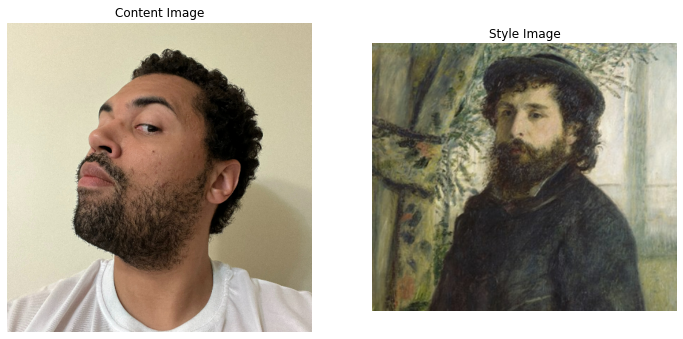

In [39]:
# Link Profile
content_image = load_img(me_path[1])
style_image = load_img(art_paths[1])

plt.subplot(1, 2, 1)
imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_image, 'Style Image')

# Fast Style Transfer using TF-Hub

Using TensorFlow's pre-trained model as can be found at [TensorFlow Hub Models](https://tfhub.dev/)


### Overview
As detailed by [tfhub](https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2) 
> The original work for artistic style transfer with neural networks proposed a slow optimization algorithm that works on any arbitrary painting. Subsequent work developed a method for fast artistic style transfer that may operate in real time, but was limited to one or a limited set of styles.
This module performs fast artistic style transfer that may work on arbitrary painting styles as described in [1].

### Example Use


```
# Load content and style images
content_image = plt.imread(content_image_path)
style_image = plt.imread(style_image_path)
# Convert to float32 numpy array, add batch dimension, and normalize to range [0, 1]. Example using numpy:
content_image = content_image.astype(np.float32)[np.newaxis, ...] / 255.
style_image = style_image.astype(np.float32)[np.newaxis, ...] / 255.
# Optionally resize the images. It is recommended that the style image is about
# 256 pixels (this size was used when training the style transfer network).
# The content image can be any size.
style_image = tf.image.resize(style_image, (256, 256))

# Load image stylization module.
hub_module = hub.load('https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2')

# Stylize image.
outputs = hub_module(tf.constant(content_image), tf.constant(style_image))
stylized_image = outputs[0]

```

[1](https://arxiv.org/pdf/1705.06830.pdf)


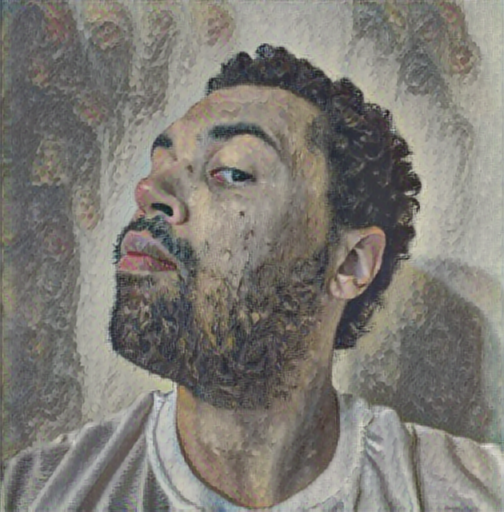

In [40]:
import tensorflow_hub as hub
hub_model = hub.load("https://tfhub.dev/google/magenta/arbitrary-image-stylization-v1-256/2")
stylized_image = hub_model(tf.constant(content_image), tf.constant(style_image))[0]
tensor_to_image(stylized_image)

# Defining Content and Style Representations